In [10]:
%load_ext autoreload
%autoreload

import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from equationmodel_gp import gp_regression, prediction_rmse_error, gp_train_graph, gp_linear_compare_graph
from util import ADD_data_loader, combineDF, filteringDF, getFreeSpacePathLoss, makeXforGraph

desired_width=620
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns',30)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload

iksan_fileList = {'../data/PLdata_iksan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_iksan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
nonsan_fileList = {'../data/PLdata_nonsan_wt_400.csv':[('frequency', 400), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_1399.csv':[('frequency', 1399), ('heightTB',30), ('heightB',15), ('heightM',2)],
            '../data/PLdata_nonsan_wt_2249.csv':[('frequency', 2249), ('heightTB',30), ('heightB',15), ('heightM',2)]}
paju_fileList = {'../data/PLdata_paju_wt_400.csv':[('frequency', 400), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_1399.csv':[('frequency', 1399), ('heightTB',100), ('heightB',7), ('heightM',2)],
            '../data/PLdata_paju_wt_2249.csv':[('frequency', 2249), ('heightTB',100), ('heightB',7), ('heightM',2)]}

addIksan = ADD_data_loader(iksan_fileList)
print("Iksan data:",addIksan.shape)
print("")
addNonsan = ADD_data_loader(nonsan_fileList)
print("Nonsan data:",addNonsan.shape)
print("")
addPaju = ADD_data_loader(paju_fileList)
print("Paju data:",addPaju.shape)
print("")

# print(addIksan.describe())
# print(addNonsan.describe())
# print(addPaju.describe())

addData = combineDF([addIksan, addNonsan, addPaju])
print("antenna_b height filtering-before(data count):",addData.shape)
addData = filteringDF(addData, 'heightTM', [10,100])
print("antenna_b height filtering-after(data count):",addData.shape)

print("freespace pathloss filtering-before(data count):",addData.shape)
addData['freePathloss'] = getFreeSpacePathLoss(addData['distance'],addData['frequency'])
addData = addData[addData['pathloss'] >= addData['freePathloss']]
print("freespace pathloss filtering-after(data count):",addData.shape)

# print("ADD data sample:\n",addData.head())

print("\nADD data description")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())
print("\nCovariance Matrix - ADD data")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].cov())
print("--------------------------------------------------")

ADD data preprocessing
../data/PLdata_iksan_wt_2249.csv: distance filtering(before):(108873, 4)
../data/PLdata_iksan_wt_2249.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(before):(109060, 4)
../data/PLdata_iksan_wt_1399.csv: distance filtering(after):(10396, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(before):(109210, 4)
../data/PLdata_iksan_wt_400.csv: distance filtering(after):(10396, 4)
Combined data set: (31188, 8)
type filtering(before):(31188, 8)
type filtering(after):(21210, 8)
Dataframe before add constant feature: (21210, 8)
Dataframe after add constant feature: (21210, 16)
Iksan data: (21210, 16)

ADD data preprocessing
../data/PLdata_nonsan_wt_400.csv: distance filtering(before):(114545, 4)
../data/PLdata_nonsan_wt_400.csv: distance filtering(after):(14603, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(before):(114341, 4)
../data/PLdata_nonsan_wt_2249.csv: distance filtering(after):(14603, 4)
../data/PLda

In [14]:
%autoreload

print("ADD distribution")
print(addData[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())

print("sampling(before):{}".format(addData.shape))
addDataSample = addData.sample(frac=0.1, replace=True, random_state=1)
print("sampling(after):{}".format(addDataSample.shape))

print("ADDsample distribution")
print(addDataSample[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance', 'pathloss']].describe())

X = np.array(addDataSample[['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']])
Y = np.array(addDataSample[['pathloss']])

kf = KFold(n_splits=5,shuffle=True)
kf.get_n_splits(X)

modelList = []
dataSet = []
i = 1
for train_index, test_index in kf.split(X):
#     print("TRAIN index:", train_index, "TEST index:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
    print("X_train shape:{}, y_train shape:{}, X_test shape:{}, y_test shape:{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))
    model = gp_regression(X_train, y_train.flatten())

#     trainError = prediction_rmse_error(model.predict(X_train), y_train)
#     testError = prediction_rmse_error(model.predict(X_test), y_test)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    trainError = np.sqrt(mean_squared_error(y_train, pred_train))
    testError = np.sqrt(mean_squared_error(y_test, pred_test))

    print("GP-Model-"+str(i)+"-train error(RMSE):", trainError)
    print("GP-Model-"+str(i)+"-test error(RMSE):", testError)    
    
    dataSet.append([X_train,y_train,X_test,y_test, trainError, testError])
    
    modelList.append(model)
    filename = 'model/gp_model_' + str(i) + '.sav'
    pickle.dump(modelList[-1], open(filename, 'wb'))
    i+=1

ADD distribution
       logDistance  logFrequency   logHeightB   logHeightM  logHeightTratio  logAntennaMulLogDistance     pathloss
count  79125.00000   79125.00000  79125.00000  79125.00000      79125.00000               79125.00000  79125.00000
mean       0.30807       3.03282      1.05325      0.30103         -3.32041                   0.32494    127.46660
std        0.11901       0.31582      0.15991      0.00000          0.32522                   0.13568     16.61257
min        0.00003       2.60206      0.84510      0.30103         -4.00000                   0.00004     85.05800
25%        0.23252       2.60206      0.84510      0.30103         -3.62342                   0.23656    114.90700
50%        0.32884       3.14582      1.17609      0.30103         -3.27300                   0.33415    127.16800
75%        0.39827       3.35199      1.17609      0.30103         -3.04899                   0.41372    140.50700
max        0.47708       3.35199      1.17609      0.30103     

X shape:(6329, 6), Y shape:(6329, 1)
tmpCombined:(6329, 7)
tmpDF size:(2072, 7)
tmpDF size:(2126, 7)
tmpDF size:(2131, 7)


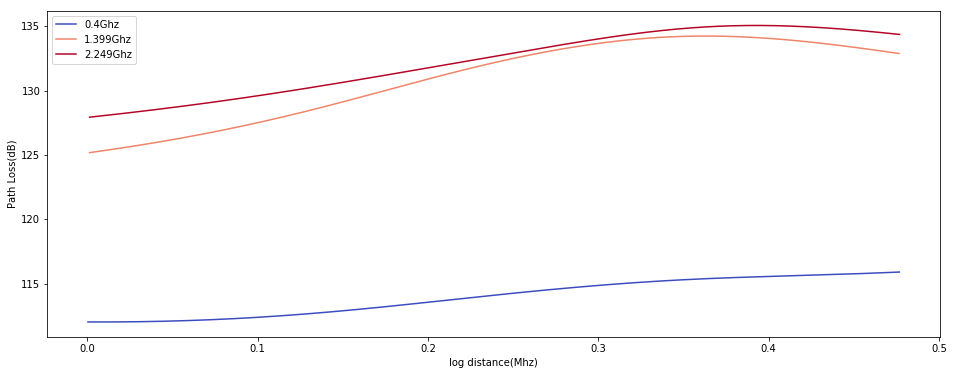

X shape:(6329, 6), Y shape:(6329, 1)
tmpCombined:(6329, 7)
tmpDF size:(2063, 7)
tmpDF size:(2123, 7)
tmpDF size:(2143, 7)


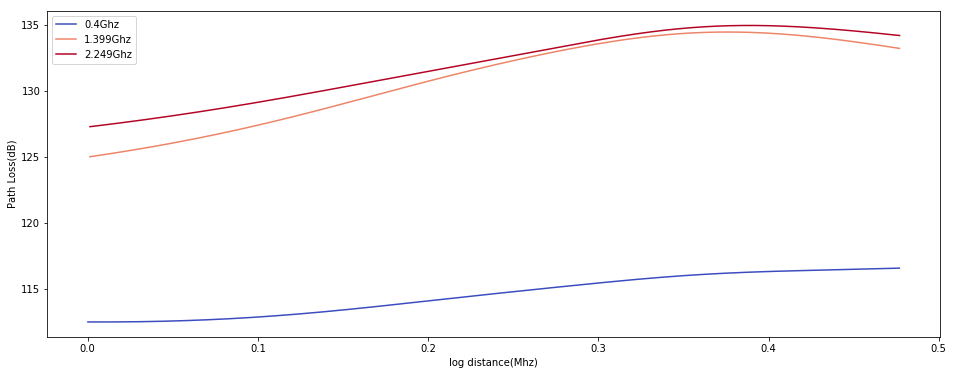

X shape:(6330, 6), Y shape:(6330, 1)
tmpCombined:(6330, 7)
tmpDF size:(2089, 7)
tmpDF size:(2127, 7)
tmpDF size:(2114, 7)


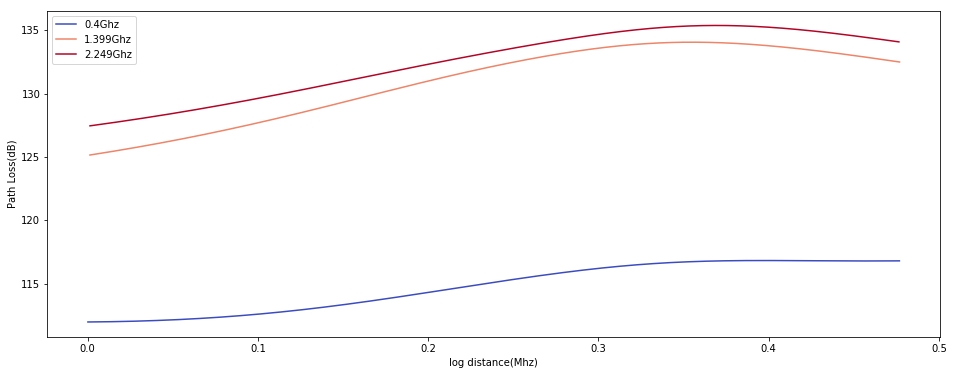

X shape:(6330, 6), Y shape:(6330, 1)
tmpCombined:(6330, 7)
tmpDF size:(2084, 7)
tmpDF size:(2085, 7)
tmpDF size:(2161, 7)


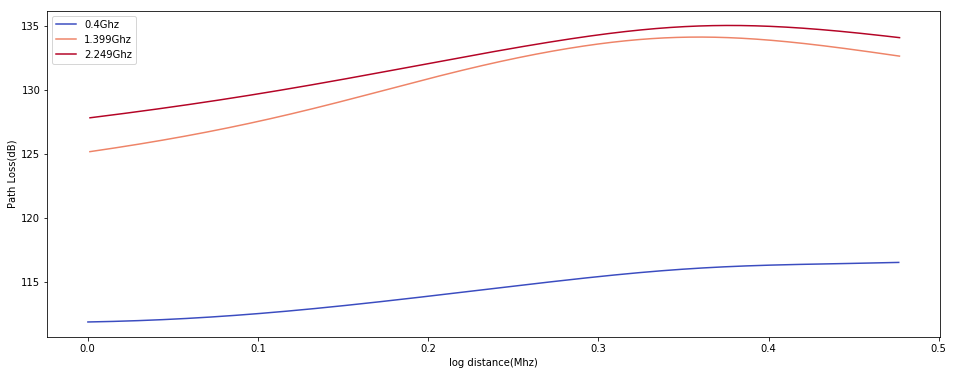

X shape:(6330, 6), Y shape:(6330, 1)
tmpCombined:(6330, 7)
tmpDF size:(2080, 7)
tmpDF size:(2111, 7)
tmpDF size:(2139, 7)


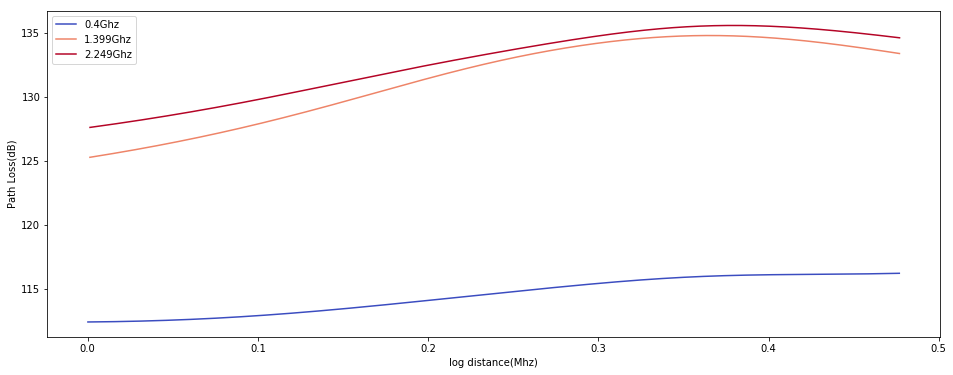

In [15]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']))

    model = pickle.load(open("model/gp_model_"+ str(i) +".sav", 'rb'))

    graphX = data[0]
    graphY = data[1]
    gp_train_graph(model, graphX, graphY)
    i+=1

In [11]:
%autoreload

#['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']

i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:   
    print("\n<GP model #" + str(i) + ">")
    print("========================================")
    GPmodel = pickle.load(open("model/gp_model_"+ str(i) +".sav", 'rb')) 
    
    GPPred = GPmodel.predict(X_train)
    linearModel = Ridge(alpha=1.0).fit(X_train, GPPred)
        
    linearPred = linearModel.predict(X_train)
    print("score:",linearModel.score(X_train, y_train))
    print("coefficient:",linearModel.coef_)
    print("intercept:",linearModel.intercept_)
    
    similarity = np.sqrt(mean_squared_error(GPPred, linearPred))
    RMSE = np.sqrt(mean_squared_error(y_train, linearPred))
    print("Similarity(GP-MultiLinear) - RMSE:", similarity)
    print("RMSE with true pathloss:", RMSE)
    print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb/h_tbm) + {:6.2f}log_d*log_hb + {:6.2f}".format(linearModel.coef_[0],linearModel.coef_[1],linearModel.coef_[2],linearModel.coef_[3],linearModel.coef_[4],linearModel.coef_[5],linearModel.intercept_))
    i+=1


<GP model #1>
score: 0.417795855817351
coefficient: [-1.80646241e+01  2.64691037e+01 -2.03701476e+01  2.10182280e-09
  1.68514597e+01  4.77285928e+01]
intercept: 114.50218117603131
Similarity(GP-MultiLinear) - RMSE: 12.640882889493431
RMSE with true pathloss: 12.768073455542487
L_pathloss = -18.06log_d +  26.47log_f + -20.37log_hb +   0.00log_hm +  16.85log_(h_tb/h_tbm) +  47.73log_d*log_hb + 114.50

<GP model #2>
score: 0.41878462935328764
coefficient: [-2.12791216e+01  2.64792888e+01 -2.02423746e+01  4.30808167e-09
  1.68667061e+01  4.97433477e+01]
intercept: 114.79409628455197
Similarity(GP-MultiLinear) - RMSE: 12.003860611248475
RMSE with true pathloss: 12.715095450758996
L_pathloss = -21.28log_d +  26.48log_f + -20.24log_hb +   0.00log_hm +  16.87log_(h_tb/h_tbm) +  49.74log_d*log_hb + 114.79

<GP model #3>
score: 0.40835850965472686
coefficient: [-2.27322015e+01  2.64637234e+01 -2.02631895e+01  3.70239038e-09
  1.64112153e+01  5.02461964e+01]
intercept: 113.5667151858232
Similar

X shape:(3164, 6), Y shape:(3164, 1)
tmpCombined:(3164, 7)
tmpDF size:(1070, 7)
tmpDF size:(1035, 7)
tmpDF size:(1059, 7)


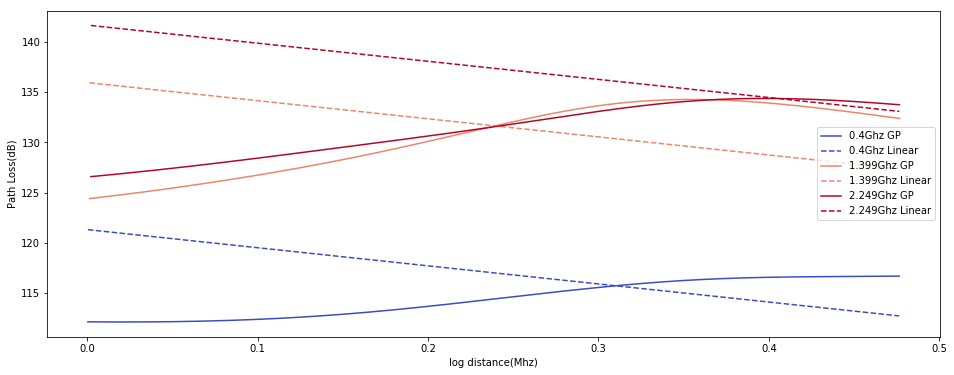

Similarity(GP-MultiLinear) - RMSE: 12.640882889492245
L_pathloss = -18.06log_d +  26.47log_f + -20.37log_hb +   0.00log_hm +  16.85log_(h_tb/h_tbm) +  47.73log_d*log_hb + 114.50
X shape:(3165, 6), Y shape:(3165, 1)
tmpCombined:(3165, 7)
tmpDF size:(1055, 7)
tmpDF size:(1048, 7)
tmpDF size:(1062, 7)


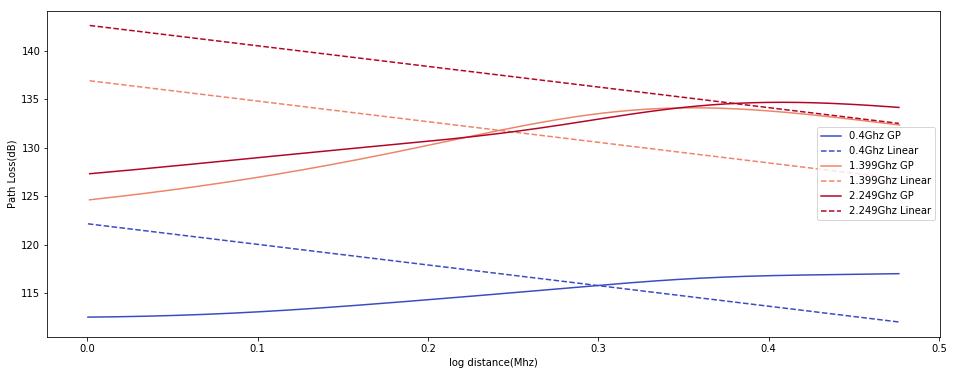

Similarity(GP-MultiLinear) - RMSE: 12.003860611248363
L_pathloss = -21.28log_d +  26.48log_f + -20.24log_hb +   0.00log_hm +  16.87log_(h_tb/h_tbm) +  49.74log_d*log_hb + 114.79
X shape:(3165, 6), Y shape:(3165, 1)
tmpCombined:(3165, 7)
tmpDF size:(1055, 7)
tmpDF size:(1058, 7)
tmpDF size:(1052, 7)


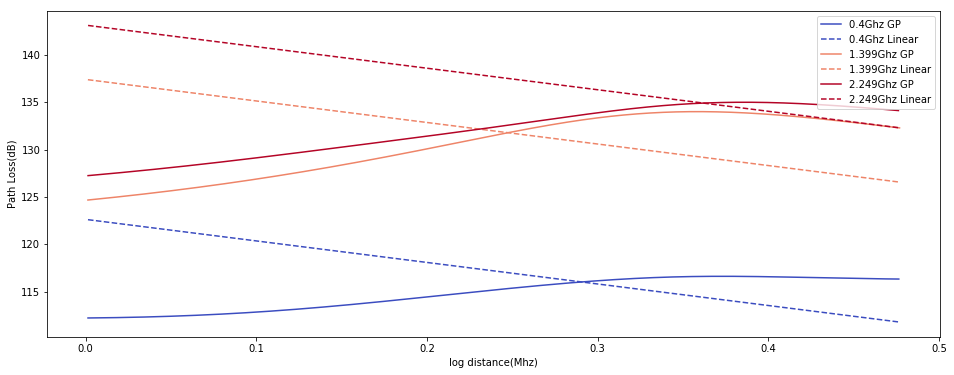

Similarity(GP-MultiLinear) - RMSE: 12.206023623599755
L_pathloss = -22.73log_d +  26.46log_f + -20.26log_hb +   0.00log_hm +  16.41log_(h_tb/h_tbm) +  50.25log_d*log_hb + 113.57
X shape:(3165, 6), Y shape:(3165, 1)
tmpCombined:(3165, 7)
tmpDF size:(1050, 7)
tmpDF size:(1053, 7)
tmpDF size:(1062, 7)


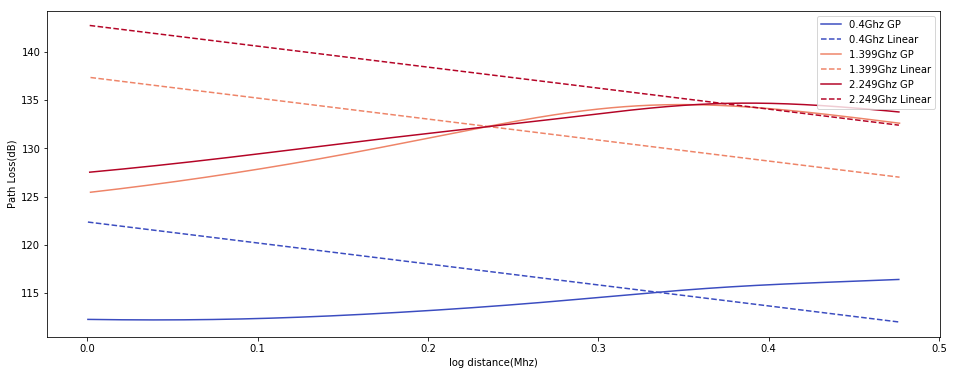

Similarity(GP-MultiLinear) - RMSE: 12.673430980414464
L_pathloss = -21.82log_d +  26.14log_f + -21.00log_hb +   0.00log_hm +  17.23log_(h_tb/h_tbm) +  50.22log_d*log_hb + 117.85
X shape:(3165, 6), Y shape:(3165, 1)
tmpCombined:(3165, 7)
tmpDF size:(1050, 7)
tmpDF size:(1062, 7)
tmpDF size:(1053, 7)


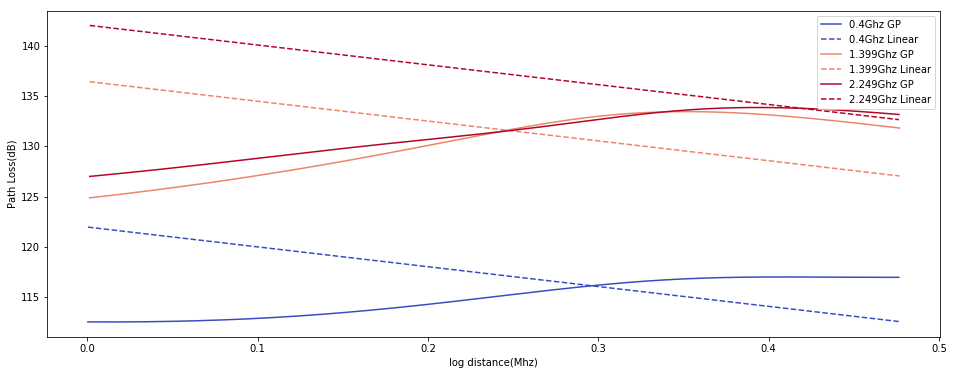

Similarity(GP-MultiLinear) - RMSE: 12.182185307224419
L_pathloss = -19.68log_d +  25.89log_f + -21.42log_hb +   0.00log_hm +  17.71log_(h_tb/h_tbm) +  45.83log_d*log_hb + 121.42


In [13]:
%autoreload
i = 1
for X_train,y_train,X_test,y_test, trainError, testError in dataSet:
    
    data = makeXforGraph(pd.DataFrame(X_train, columns=['logDistance', 'logFrequency', 'logHeightB', 'logHeightM', 'logHeightTratio', 'logAntennaMulLogDistance']),
                         pd.DataFrame(y_train, columns=['pathloss']))

    GPmodel = pickle.load(open("model/gp_model_"+ str(i) +".sav", 'rb'))
    GPPred = GPmodel.predict(X_train)
    
    linearModel = Ridge(alpha=1.0).fit(X_train, GPPred)     
    linearPred = linearModel.predict(X_train)
    
    graphX = data[0]
    graphY = data[1]
    gp_linear_compare_graph(GPmodel, linearModel, graphX, graphY)
#     print("coefficient:",linearModel.coef_)
#     print("intercept:",linearModel.intercept_)
    
    similarity = np.sqrt(mean_squared_error(GPPred, linearPred))
    print("Similarity(GP-MultiLinear) - RMSE:", similarity)
    print("L_pathloss = {:6.2f}log_d + {:6.2f}log_f + {:6.2f}log_hb + {:6.2f}log_hm + {:6.2f}log_(h_tb/h_tbm) + {:6.2f}log_d*log_hb + {:6.2f}".format(linearModel.coef_[0],linearModel.coef_[1],linearModel.coef_[2],linearModel.coef_[3],linearModel.coef_[4],linearModel.coef_[5],linearModel.intercept_))

    i+=1